## Model validation trained on different combinations of the datasets.

In this notebook we investigate how models perfomance, in particular MAE metrics, on the dataset depends on the data the model saw during training stage.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex, KNNIndex
from seismicpro.models import PickingMetrics

Define 3 different datasets. The first 40 fields of each dataset was used for training.

In [2]:
path_raw = '/data/FB/dataset_5/1_FBP_etalon_50_ffid.sgy'
markup_path = '/data/FB/dataset_5/1_FBP_manual_pick_50_ffid_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_data_1 = Dataset(TraceIndex(index.create_subset(index.indices[40:])), SeismicBatch)

In [3]:
path_raw = '/data/FB/dataset_6/3_FBP_input_ffid_raw-500_off-800.sgy'
markup_path = '/data/FB/dataset_6/3_FBP_manual_flatiron_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_data_2 = Dataset(TraceIndex(index.create_subset(index.indices[40:])), SeismicBatch)

In [4]:
path_raw = '/data/FB/dataset_4/5_FBP_etalon_54_ffid.sgy'
markup_path = '/data/FB/dataset_4/5_FBP_manual_pick_54_ffid_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_data_3 = Dataset(TraceIndex(index.create_subset(index.indices[40:])), SeismicBatch)

In [9]:
test_data = [test_data_1, test_data_2, test_data_3]

Specify paths to saved trained models. We run the same training process twice in order to make sure that results will not differ much from train to train.

In [10]:
models_paths_v1 = ['all_pretrained.dill', 'all_slice.dill', 'pal+vor_v2.dill', 'pal+wz_v2.dill', 
                'wz+vor_v2.dill', 'vor_v2.dill','wz_v2.dill', 'pal_v2.dill']

In [11]:
models_paths_v2 = ['all_pretrained_v3.dill', 'all_slice.dill', 'pal+vor_v3.dill', 'wz+pal_v3.dill', 
                'wz+vor_v3.dill', 'vor_v3.dill','wz_v3.dill', 'pal_v3.dill']

Evaluate scores for the models in the first training iteration.

In [12]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [13]:
scores_1 = []
for data in test_data:
    mae = []
    for model_path in models_paths_v1:
        test_pipeline = pipeline(model_path)
        (test_pipeline << data).run()
        
        pred = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))
        true = np.argmax(np.stack(np.concatenate(test_pipeline.get_variable('picking'))), axis=1)
        
        metrics = PickingMetrics(true, pred, gap=3)
        mae.append(metrics.evaluate('mae'))
    
    scores_1.append(mae)

Scores for same models from the second iteration.

In [28]:
len(scores_1[0])

8

In [14]:
scores_2 = []
for data in test_data:
    mae = []
    for model_path in models_paths_v2:
        test_pipeline = pipeline(model_path)
        (test_pipeline << data).run()
        
        pred = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))
        true = np.argmax(np.stack(np.concatenate(test_pipeline.get_variable('picking'))), axis=1)
        
        metrics = PickingMetrics(true, pred, gap=3)
        mae.append(metrics.evaluate('mae'))
    
    scores_2.append(mae)

Draw results.

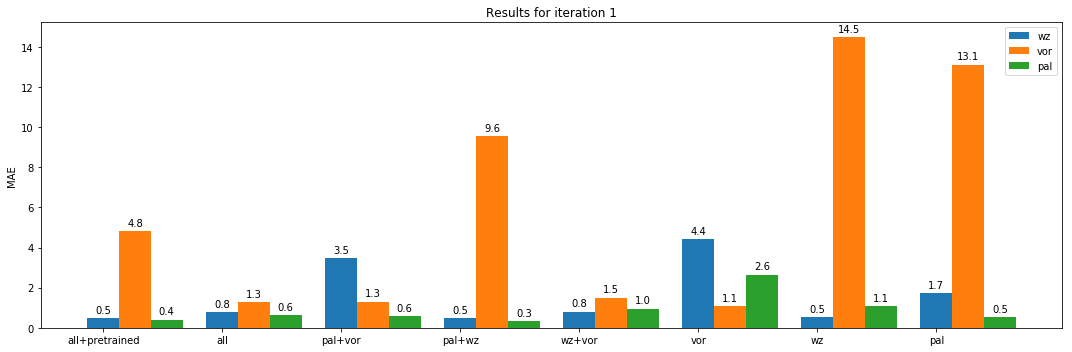

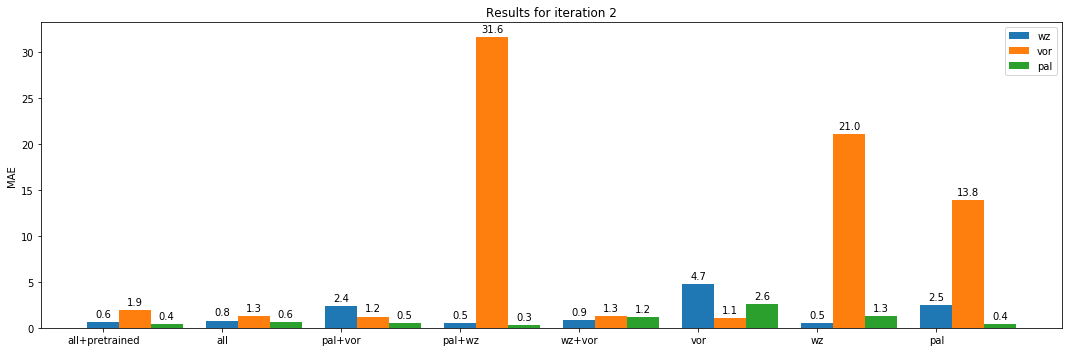

In [50]:
plot_bars(scores_1, 1)
plot_bars(scores_2, 2)

First of all the proportion of rectangles preserve in 2 training iterations.   
Besides, it can be seen that the model should 'see' traces from vor dataset during training stage in oder to make good predictions on this traces during evaluation stage.

In [49]:
def plot_bars(scores, iteration):
    labels = ['all+pretrained', 'all', 'pal+vor', 'pal+wz', 'wz+vor', 'vor', 'wz', 'pal']
    wz, vor, pal = scores[0], scores[1], scores[2]
    x = np.arange(0, 3 * len(labels), 3)  # the label locations
    width = 0.8   # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 5))
    rects1 = ax.bar(x , wz, width, label='wz')
    rects2 = ax.bar(x + width, vor, width, label='vor')
    rects3 = ax.bar(x + 2 * width, pal, width, label='pal')

    ax.set_ylabel('MAE')
    ax.set_title('Results for iteration {}'.format(iteration))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.1f}'.format((height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

In [8]:
def pipeline(model_path):
        config_predict = {
            'build': False,
            'load/path':  model_path,
            'device': 'gpu:0'
        }

        test_pipeline = (Pipeline()
                        .init_model('dynamic', UNet, 'my_model', config=config_predict) 
                        .load(components='raw', fmt='segy', tslice=np.arange(751))
                        .load(components='markup', fmt='picks')
                        .standartize(src='raw', dst='raw')
                        .picking_to_mask(src='markup', dst='mask')
                        .add_components(components='unet_predictions')
                        .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                        .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                        .add_components(components='predictions')
                        .predict_model('my_model', B('raw'), fetches='predictions',
                                        save_to=B('predictions', mode='a'))
                        .init_variable('picking', init_on_each_run=list())
                        .update_variable('picking', B('mask'), mode='a')
                        .init_variable('traces', init_on_each_run=list())
                        .update_variable('traces', B('raw'), mode='a')
                        .mask_to_pick(src='predictions', dst='predictions', labels=False)
                        .init_variable('predictions', init_on_each_run=list())
                        .update_variable('predictions', B('predictions'), mode='a')
                        .run_later(500, n_epochs=1, drop_last=False, shuffle=False, bar=False))
        
        return test_pipeline